In [1]:
from pathlib import Path
import numpy as np
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
from sklearn.model_selection import train_test_split

DATA_DIR = Path.cwd().parent / "data" / "cifar10_torch_np"
DATA_DIR.mkdir(parents=True, exist_ok=True)

CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
SEED = 42
VAL_SIZE = 0.10
GRAYSCALE = True
SUBSET = None
rng = np.random.default_rng(SEED)
torch.manual_seed(SEED)

In [8]:
def load_cifar10_numpy_fast(grayscale=True, val_size=0.10, subset=None, seed=42):
    root = DATA_DIR

    train_raw = CIFAR10(root=str(root), train=True,  download=True, transform=None)
    test_raw  = CIFAR10(root=str(root), train=False, download=True, transform=None)

    X_train = train_raw.data
    y_train = np.array(train_raw.targets, dtype=np.int64)
    X_test  = test_raw.data
    y_test  = np.array(test_raw.targets, dtype=np.int64)

    if subset is not None and subset < X_train.shape[0]:
        rs = np.random.RandomState(seed)
        idx = rs.permutation(X_train.shape[0])[:subset]
        X_train = X_train[idx]
        y_train = y_train[idx]

    if grayscale:
        # Grayscale, scale & flatten
        X_train = X_train.mean(axis=3).astype(np.float32) / 255.0
        X_test  = X_test.mean(axis=3).astype(np.float32) / 255.0
        X_train = X_train.reshape(len(X_train), -1)
        X_test  = X_test.reshape(len(X_test), -1)
    else:
        # RGB, scale & flatten
        X_train = (X_train.astype(np.float32) / 255.0).reshape(len(X_train), -1)
        X_test  = (X_test.astype(np.float32)  / 255.0).reshape(len(X_test),  -1)

    # stratified validation split
    Xtr, Xval, ytr, yval = train_test_split(
        X_train, y_train, test_size=val_size, random_state=seed, stratify=y_train
    )

    return (Xtr.astype(np.float32), ytr.astype(np.int64),
            Xval.astype(np.float32), yval.astype(np.int64),
            X_test.astype(np.float32), y_test.astype(np.int64))


In [7]:
Xtr, ytr, Xval, yval, Xte, yte = load_cifar10_numpy_fast(GRAYSCALE, VAL_SIZE, SUBSET, SEED)
Xtr.shape, Xval.shape, Xte.shape, (Xtr.min(), Xtr.max()), np.bincount(ytr)[:10]

100.0%


((45000, 1024),
 (5000, 1024),
 (10000, 1024),
 (np.float32(0.0), np.float32(1.0)),
 array([4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500]))

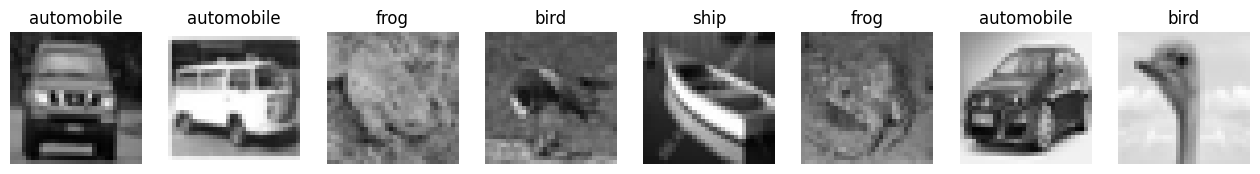

In [9]:
import matplotlib.pyplot as plt

def show_samples(X, y, n=8, grayscale=True):
    D = X.shape[1]
    C = 1 if grayscale else 3
    H = W = 32
    fig, axes = plt.subplots(1, n, figsize=(2*n, 2))
    for i, ax in enumerate(axes):
        img = X[i].reshape(C, H, W)
        if grayscale:
            ax.imshow(img[0], cmap='gray', vmin=0, vmax=1)
        else:
            ax.imshow(img.transpose(1, 2, 0))
        ax.set_title(CLASS_NAMES[y[i]])
        ax.axis('off')
    plt.show()

show_samples(Xtr, ytr, n=8, grayscale=GRAYSCALE)

In [10]:
suffix = "gray" if GRAYSCALE else "rgb"
out = DATA_DIR / f"cifar10_{suffix}_val{int(VAL_SIZE*100)}.npz"
np.savez_compressed(out, Xtr=Xtr, ytr=ytr, Xval=Xval, yval=yval, Xte=Xte, yte=yte)
out, out.stat().st_size/1e6

(WindowsPath('c:/Users/BIT/Complete_ML/DNN_CIFAR10/data/cifar10_torch_np/cifar10_gray_val10.npz'),
 99.383394)